In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras import regularizers
import os 
import tempfile
from keras import applications

In [ ]:
#%%
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#%%

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_InceptionV31.h5', monitor='val_loss', save_best_only=True)]

#%%
# add preprocessing layer to the front of VGG
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#%%

In [ ]:
'''regularizer = tf.keras.regularizers.l2(l=0.5)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)'''
          
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.75)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model
          
#%%
  
add_regularization(base_model)

#%%
    

In [ ]:
for layer in base_model.layers:
  layer.trainable = False
  
base_model.summary()
 
#%% 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#%%
# our layers - you can add more if you want
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

#%%
# create a model object
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# view the structure of the model
model.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.RMSprop(lr=1e-4),
  metrics=['accuracy']
)


#%%
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#%%

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
'''import os
import shutil
directory = '/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC'
s=os.listdir(directory)
print(s)
for filename in s:
    if filename.endswith(".png"):
      print(filename)
      shutil.copyfile('/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC/'+filename,'/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train/NC/'+filename)
      #os.remove('/content/drive/MyDrive/hippodeep_pytorch-master/NC/NC/'+filename)
      continue
    else:
      continue'''

'import os\nimport shutil\ndirectory = \'/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC\'\ns=os.listdir(directory)\nprint(s)\nfor filename in s:\n    if filename.endswith(".png"):\n      print(filename)\n      shutil.copyfile(\'/content/drive/MyDrive/hippodeep_pytorch-master/NC/2d_NC/\'+filename,\'/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train/NC/\'+filename)\n      #os.remove(\'/content/drive/MyDrive/hippodeep_pytorch-master/NC/NC/\'+filename)\n      continue\n    else:\n      continue'

In [ ]:

#%%

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Train',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

#%%

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Test',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

#%%

validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Transfer Learning Codes/Transfer/Validation',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

#%%


Found 553 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [ ]:
initial_epochs = 150

history = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=initial_epochs,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=callbacks
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
18/18 [==============================] - 176s 9s/step - loss: 0.9743 - accuracy: 0.5073 - val_loss: 1.1579 - val_accuracy: 0.3548
Epoch 2/150
18/18 [==============================] - 145s 8s/step - loss: 0.8960 - accuracy: 0.6147 - val_loss: 1.1369 - val_accuracy: 0.3548
Epoch 3/150
18/18 [==============================] - 144s 8s/step - loss: 0.9454 - accuracy: 0.5986 - val_loss: 1.0898 - val_accuracy: 0.3710
Epoch 4/150
18/18 [==============================] - 145s 8s/step - loss: 0.9190 - accuracy: 0.5828 - val_loss: 1.1935 - val_accuracy: 0.3871
Epoch 5/150
18/18 [==============================] - 145s 8s/step - loss: 0.9190 - accuracy: 0.5743 - val_loss: 1.1781 - val_accuracy: 0.3871
Epoch 6/150
18/18 [==============================] - 144s 8s/step - loss: 0.8968 - accuracy: 0.5887 - val_loss: 1.1383 - val_accuracy: 0.3548
Epoch 7/150
18/18 [==============================] - 145s 8s/step - loss: 0.9189 - accuracy: 0.5875 - val_loss: 1.1634 - val_accuracy: 0.3871
Epoch 

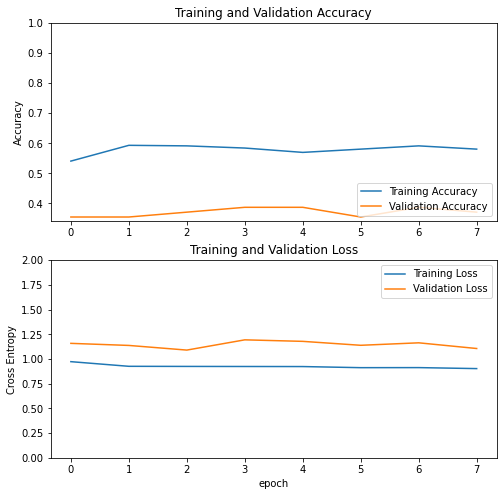

Number of layers in the base model:  780
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 12,845,251
Non-trainable params: 41,496,096
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 8/106
18/18 [==============================] - 192s 10s/step - loss: 0.9544 - accuracy: 0.5387 - val_loss: 1.5786 - val_accuracy: 0.4677
Epoch 9/106
18/18 [==============================] - 173s 10s/step - loss: 0.7483 - accuracy: 0.6858 - val_loss: 1.6272 - val_accuracy: 0.5161
Epoch 10/106
18/18 [==============================] - 174s 10s/step - loss: 0.6613 - accuracy: 0.7300 - val_loss: 1.5783 - val_accuracy: 0.5806
Epoch 11/106
18/18 [==============================] - 176s 10s/step - loss: 0.6053 - accuracy: 0.7742 - val_loss: 1.9574 - val_accuracy: 0.5806
Epoch 12/106
18/18 [==============================] - 174s 10s/step - loss: 0.4872 - accuracy: 0.8138 - val_loss: 2.4031 - val_accuracy: 0.4516
Epoch 13/106
18/18 [==============================] - 175s 10s/step - loss: 0.4050 - accuracy: 0.8429 - val_loss: 3.2063 - val_accuracy: 0.4355
Epoch 14/106
18/18 [==============================] - 174s 10s/step - loss: 0.3424 - accuracy: 0.8853 - val_loss: 2.6448 - val_accuracy: 0

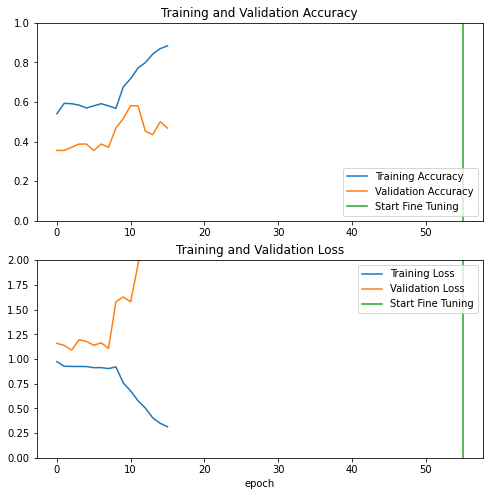

"acc = history.history['acc']\nval_acc = history.history['val_acc']\nloss = history.history['loss']\nval_loss = history.history['val_loss']\nepochs = range(len(acc))\nplt.plot(epochs, acc, 'r', label='Training acc')\nplt.plot(epochs, val_acc, 'b', label='Validation acc')\nplt.title('Training and validation accuracy')\nplt.ylabel('accuracy')  \nplt.xlabel('epoch')\nplt.legend()\nplt.figure()\nplt.plot(epochs, loss, 'r', label='Training loss')\nplt.plot(epochs, val_loss, 'b', label='Validation loss')\nplt.title('Training and validation loss')\nplt.ylabel('loss')  \nplt.xlabel('epoch')\nplt.legend()\nplt.show()"

In [ ]:



#%%
'''r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)'''

#%%

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#%%

base_model.trainable = True

#%%

print("Number of layers in the base model: ", len(base_model.layers))

#%%

fine_tune_at = 702

#%%

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  
#%%
  
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.RMSprop(lr=1e-4),
  metrics=['accuracy']
)  

#%%

model.summary()

#%%

len(model.trainable_variables)

#%%
initial_epochs=56
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

#%%
history_fine = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=total_epochs,
  initial_epoch=history.epoch[-1],
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=callbacks
)


#%%

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#%%

'''acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()'''